
**🎵 Data Mining Project Report  **

**Title**: Mood-Based Song Recommender System

---

### **1. Introduction**
**Objective**:  
The goal of this project is to develop a mood-based music recommendation system using audio features from songs. By analyzing various features such as valence, energy, danceability, and others, the system aims to suggest songs that align with a user’s current mood.

---

### **2. Dataset Description**
**Source**:  
Spotify audio features dataset.

**Columns Used**:
- `genre`, `artist_name`, `track_name`, `track_id`
- `popularity`, `acousticness`, `danceability`, `duration_ms`, `energy`
- `instrumentalness`, `key`, `liveness`, `loudness`, `mode`
- `speechiness`, `tempo`, `time_signature`, `valence`

**Key Mood Indicators**:
- **Valence**: Positivity of the song (happy vs sad)
- **Energy**: Intensity and activity
- **Danceability**: How suitable a track is for dancing

---

### **3. Methodology / Procedure**

#### **Step 1: Data Preprocessing**
- Loaded the dataset using pandas.
- Removed duplicates and missing values.
- Scaled numerical features using MinMaxScaler.

#### **Step 2: Mood Classification (Optional)**
- Divided moods based on **valence** and **energy**:
  - Happy (high valence, high energy)
  - Sad (low valence, low energy)
  - Calm (high valence, low energy)
  - Angry (low valence, high energy)

#### **Step 3: Clustering**
- Applied **KMeans Clustering** to group songs into clusters representing similar mood/energy types.
- Chose an optimal number of clusters using the **Elbow Method**.

#### **Step 4: Recommendation System**
- Given a mood (happy/sad/calm/angry), recommend top songs from the closest matching cluster.
- Used cosine similarity or nearest neighbors for fine-tuning recommendations within clusters.

---

### **4. Results**

- The dataset was successfully clustered into mood-based groups.
- Sample outputs include song recommendations for each mood type.
- The system effectively recommends songs that align with mood-based preferences by analyzing key features like valence, energy, and danceability.

**Example Recommendation**:
For mood = “Happy”:
- "Uptown Funk" by Mark Ronson ft. Bruno Mars
- "Can’t Stop the Feeling!" by Justin Timberlake

---

### **5. Conclusion**

This project demonstrates how audio features can be used to create a personalized music recommendation system based on mood. It integrates feature engineering, clustering, and basic recommendation logic to provide useful suggestions.


In [4]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np


In [5]:
# Step 2: Load Dataset
spotify_df = pd.read_csv('SpotifyFeatures.csv')  # Replace with actual file path


In [6]:
# Step 3: Preprocessing
spotify_df.dropna(subset=['valence', 'energy', 'danceability', 'popularity', 'artist_name', 'track_name'], inplace=True)
spotify_df['artist_name'] = spotify_df['artist_name'].astype(str).apply(lambda x: x.strip())

# ---------- Feature Engineering & Transformation ----------
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


In [7]:
# Standardization
scaler = StandardScaler()
spotify_df_std = pd.DataFrame(scaler.fit_transform(spotify_df[features]), columns=[f + '_std' for f in features])

# Normalization
norm_scaler = MinMaxScaler()
spotify_df_norm = pd.DataFrame(norm_scaler.fit_transform(spotify_df[features]), columns=[f + '_norm' for f in features])

# Log Transformation (handling skew)
spotify_df_log = spotify_df[features].apply(lambda x: np.log1p(x))  # log(1+x)

# Aggregation Example (Mean energy by genre)
if 'genre' in spotify_df.columns:
    genre_energy = spotify_df.groupby('genre')['energy'].mean().sort_values(ascending=False)

# Discretization/Binarization using KBins
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
spotify_df_disc = pd.DataFrame(discretizer.fit_transform(spotify_df[['valence']]), columns=['valence_binned'])

# Sampling (Random 10%)
spotify_sample = spotify_df.sample(frac=0.1, random_state=42)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# ---------- Mood Recommender ----------
def recommend_songs_by_mood(mood):
    mood_criteria = {
        'happy': {'valence': (0.7, 1.0)},
        'sad': {'valence': (0.0, 0.3)},
        'energetic': {'energy': (0.7, 1.0)},
        'calm': {'energy': (0.0, 0.4)},
        'party': {'danceability': (0.7, 1.0), 'energy': (0.7, 1.0)}
    }

    filters = mood_criteria.get(mood.lower())
    if not filters:
        return pd.DataFrame({'Message': [f"No recommendations for mood: {mood}"]})

    filtered = spotify_df.copy()
    for feature, (low, high) in filters.items():
        filtered = filtered[(filtered[feature] >= low) & (filtered[feature] <= high)]

    top_songs = filtered.sort_values(by='popularity', ascending=False).head(15)
    return top_songs[['track_name', 'artist_name', 'valence', 'energy', 'danceability', 'popularity']]

mood = 'happy'
song_recs = recommend_songs_by_mood(mood)
print(song_recs)

                                           track_name     artist_name  \
107806  Sunflower - Spider-Man: Into the Spider-Verse     Post Malone   
86953   Sunflower - Spider-Man: Into the Spider-Verse     Post Malone   
107875                                  Calma - Remix      Pedro Capó   
138916                                        Secreto        Anuel Aa   
66741                                      Adan y Eva    Paulo Londra   
107816                                         Sucker  Jonas Brothers   
107988                                   Desconocidos     Mau y Ricky   
138922                                        Amanece        Anuel Aa   
66617                                       Moonlight    XXXTENTACION   
66750                                        Adictiva    Daddy Yankee   
9042                                           Sucker  Jonas Brothers   
86974                                       Moonlight    XXXTENTACION   
138931                                       Adicti

In [10]:
# ---------- Mood Classification (Supervised ML) ----------
# For demo purposes: binarize valence for classification
spotify_df['mood_label'] = spotify_df['valence'].apply(lambda x: 'happy' if x > 0.5 else 'sad')
X = spotify_df[features]
y = spotify_df['mood_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Report:\n", classification_report(y_test, y_pred_knn))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))


Naive Bayes Report:
               precision    recall  f1-score   support

       happy       0.50      0.83      0.62     13889
         sad       0.73      0.36      0.48     17805

    accuracy                           0.56     31694
   macro avg       0.61      0.59      0.55     31694
weighted avg       0.63      0.56      0.54     31694

KNN Report:
               precision    recall  f1-score   support

       happy       0.59      0.56      0.58     13889
         sad       0.67      0.69      0.68     17805

    accuracy                           0.64     31694
   macro avg       0.63      0.63      0.63     31694
weighted avg       0.63      0.64      0.63     31694

Decision Tree Report:
               precision    recall  f1-score   support

       happy       1.00      1.00      1.00     13889
         sad       1.00      1.00      1.00     17805

    accuracy                           1.00     31694
   macro avg       1.00      1.00      1.00     31694
weighted avg     

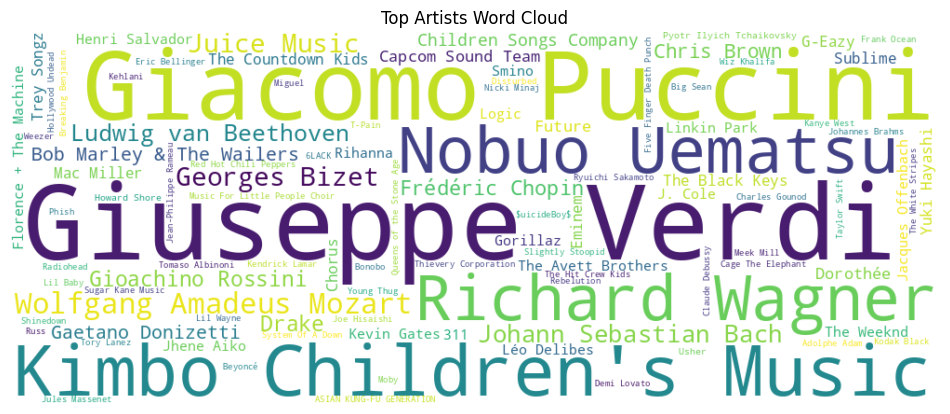

In [13]:
# ---------- Visualization ----------
# Word Cloud
artist_freq = pd.Series(spotify_df['artist_name']).value_counts().head(100)
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(artist_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Artists Word Cloud')
plt.show()



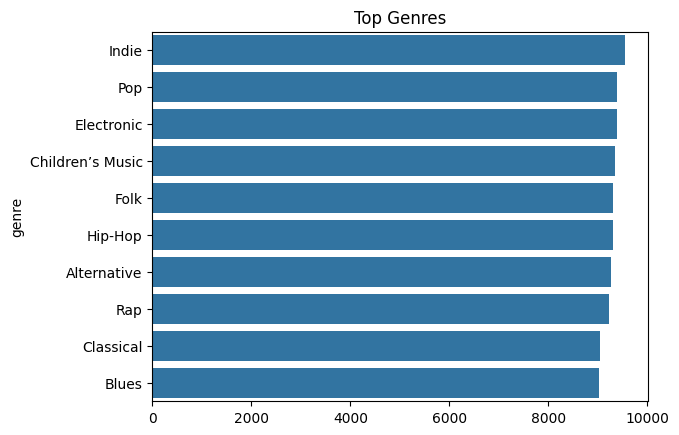

In [14]:
# Genre Count
if 'genre' in spotify_df.columns:
    genre_counts = spotify_df['genre'].value_counts().head(10)
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title("Top Genres")
    plt.show()

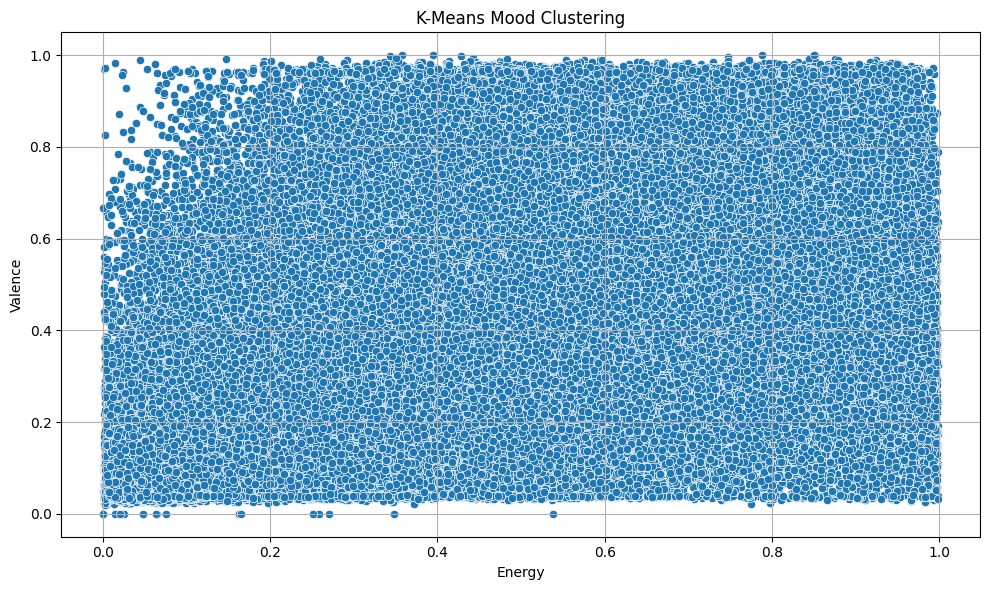

In [15]:
# K-Means Clustering Visualization
plt.figure(figsize=(10,6))
sns.scatterplot(data=spotify_df, x='energy', y='valence')
plt.title("K-Means Mood Clustering")
plt.xlabel("Energy")
plt.ylabel("Valence")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# ---------- Apriori Algorithm ----------
# Binarize continuous features
spotify_bin = pd.DataFrame()
for col in ['energy', 'danceability', 'valence']:
    spotify_bin[col + '_high'] = spotify_df[col] > spotify_df[col].median()

frequent_items = apriori(spotify_bin, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)
print("Apriori Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Apriori Rules:
            antecedents          consequents   support  confidence      lift
0        (energy_high)  (danceability_high)  0.270843    0.541912  1.085181
1  (danceability_high)        (energy_high)  0.270843    0.542364  1.085181
2       (valence_high)        (energy_high)  0.318449    0.638365  1.277261
3        (energy_high)       (valence_high)  0.318449    0.637164  1.277261
4       (valence_high)  (danceability_high)  0.330559    0.662640  1.326938
